In [1]:
import sqlalchemy
import pandas as pd
from IPython.display import HTML

from cg_analysis import (
    DB_URL,
    CG_COL_TYPES,
    CG_DATETYPE_COLS,
    LI_COL_TYPES,
    PT_COL_TYPES,
    PT_DATETYPE_COLS,
    FIN_COL_TYPES,
    FIN_DATETYPE_COLS,
    FIN_ADOPTION_COL_TYPES,
    DATA_PATH,
    OUTPUT_NET_PATH,
)
from cg_analysis import cg_query, li_query, fin_query, pt_query, fin_adoption_query

In [67]:
import importlib
import network_analysis

importlib.reload(network_analysis)

<module 'network_analysis' from '/home/robyn/repositories/data-science/investigations/one-switch/network_analysis.py'>

In [3]:
engine = sqlalchemy.create_engine(DB_URL)

# load carton grouping data
cg_df = pd.read_sql_query(
    sql=cg_query, con=engine, dtype=CG_COL_TYPES, parse_dates=CG_DATETYPE_COLS
)

# load line items data
li_df = pd.read_sql_query(sql=li_query, con=engine, dtype=LI_COL_TYPES)

# load pallet timeline data
pt_df = pd.read_sql_query(
    sql=pt_query,
    con=engine,
    dtype=PT_COL_TYPES,
    parse_dates=PT_DATETYPE_COLS,
)

# load finance data
fin_df = pd.read_sql_query(
    sql=fin_query,
    con=engine,
    dtype=FIN_COL_TYPES,
    parse_dates=FIN_DATETYPE_COLS,
)

# fin_adoption_df = pd.read_sql_query(
#     sql=fin_adoption_query,
#     con=engine,
#     dtype=FIN_ADOPTION_COL_TYPES,
# )
fin_adoption_df = pd.read_csv(
    DATA_PATH / "fin_adoption.csv",
    dtype=FIN_ADOPTION_COL_TYPES,
)

# Data cleaning


In [50]:
# load carton grouping data
cg_df = pd.read_sql_query(
    sql=cg_query, con=engine, dtype=CG_COL_TYPES, parse_dates=CG_DATETYPE_COLS
)
cg_df = cg_df.merge(
    pt_df[["cg_id", "std_cartons"]], left_on="id", right_on="cg_id", how="left"
)

In [56]:
fin_df["cgt_amount_zar"] = fin_df["cgt_amount"] * fin_df["exchange_rate"]
revenue_df = fin_df[
    (fin_df["payment_status"] != "voided")
    & (fin_df["document_type"] != "commercial_invoice")
]
cg_revenue_df = revenue_df.groupby(["cg_id", "cost_type"])["cgt_amount_zar"].sum()
cg_revenue_df = cg_revenue_df.reset_index()
cg_revenue_pivot = fin_df.pivot_table(
    index="cg_id", columns="cost_type", values="cgt_amount_zar", aggfunc="sum"
)
cg_revenue_pivot = cg_revenue_pivot.reset_index()
cg_revenue_pivot.fillna(0, inplace=True)

In [61]:
cg_df = cg_df.merge(
    cg_revenue_pivot[["cg_id", "expense", "income"]],
    left_on="id",
    right_on="cg_id",
    how="left",
)

**Why would a carton grouping have a missing buyer or seller?**


In [5]:
# Calculate the number of unique buyers and sellers
unique_buyers = cg_df["buyer_id"].nunique()
unique_sellers = cg_df["seller_id"].nunique()

print(f"Number of unique buyers: {unique_buyers}")
print(f"Number of unique sellers: {unique_sellers}")

# Calculate the number of entries with missing buyers or sellers
missing_buyer_seller_count = (
    cg_df["buyer_id"].isna().sum() + cg_df["seller_id"].isna().sum()
)

# Calculate the total number of carton groupings
total_cg_count = len(cg_df)

# Calculate the proportion of missing entries
missing_proportion = (missing_buyer_seller_count / total_cg_count) * 100

print(f"Number of entries with missing buyers or sellers: {missing_buyer_seller_count}")
print(f"Proportion of all carton groupings: {missing_proportion:.2f}%")

Number of unique buyers: 213
Number of unique sellers: 106
Number of entries with missing buyers or sellers: 106370
Proportion of all carton groupings: 12.87%


# Buyer-Seller network


In [6]:
import networkx as nx
import matplotlib.pyplot as plt


# Full buyer-seller network
buyer_seller_pairs = cg_df[["buyer_id", "seller_id"]].dropna().drop_duplicates()

# Create a graph
G = nx.Graph()

# Add edges to the graph
for _, row in buyer_seller_pairs.iterrows():
    G.add_edge(row["buyer_id"], row["seller_id"])

# Connected components


In [7]:
# List all individual connected components
connected_components = list(nx.connected_components(G))
for i, component in enumerate(connected_components):
    print(f"Connected Component {i+1}: {component}")

Connected Component 1: {1, 2, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 23, 24, 25, 26, 27, 35, 36, 37, 38, 39, 43, 44, 50, 51, 52, 53, 55, 56, 62, 63, 64, 66, 70, 71, 72, 73, 75, 110, 112, 113, 115, 120, 122, 128, 129, 130, 133, 148, 150, 152, 154, 155, 158, 162, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 178, 180, 182, 183, 185, 222, 223, 224, 227, 229, 234, 235, 237, 246, 250, 294, 345, 348, 350, 351, 356, 410, 411, 412, 413, 414, 415, 416, 417, 418, 420, 452, 461, 465, 467, 468, 469, 470, 471, 482, 484, 487, 491, 492, 494, 495, 498, 504, 505, 506, 511, 520, 525, 527, 534, 538, 539, 541, 543, 548, 551, 552, 557, 577, 582, 601, 605, 608, 635, 638, 639, 640, 641, 665, 673, 677, 683, 689, 690, 691, 693, 695, 696, 699, 700, 798, 799, 800, 802, 803, 805, 806, 830, 841, 843, 846, 848, 849, 856, 858, 861, 862, 863, 864, 865, 870, 873, 877, 878, 880, 882, 883, 884, 889, 890, 891, 950, 1005, 1012, 1024, 1061, 1083, 1085, 1088, 1093, 1095, 1099, 1107, 1126, 1190, 1245, 1251, 1417, 1450, 1

# Centrality measures

**Degree centrality**: Measures the number of direct connections a node has. Nodes with higher degree centrality are more connected.

**Betweenness centrality**: Measures the extent to which a node lies on paths between other nodes. Nodes with high betweenness centrality can control information flow in the network.

**Closeness centrality**: Measures how close a node is to all other nodes in the network. Nodes with high closeness centrality can spread information more quickly.

**Eigenvector centrality**: Measures a node's influence based on the number and quality of its connections. Nodes connected to other highly connected nodes score higher.

We consider centrality measures for the first connected component of the network


In [20]:
# Create a DataFrame with unique buyer-seller pairs, dropping any rows with missing values
buyer_seller_pairs = (
    cg_df.groupby(["buyer_id", "seller_id"])["container_number"]
    .nunique()
    .reset_index()
    .dropna()
)

# Create a graph
G = nx.Graph()

# Add edges to the graph
for _, row in buyer_seller_pairs.iterrows():
    G.add_edge(row["buyer_id"], row["seller_id"])

# Get the first connected component
connected_components = list(nx.connected_components(G))
first_component_nodes = connected_components[0]
first_component_subgraph = G.subgraph(first_component_nodes)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(first_component_subgraph)
betweenness_centrality = nx.betweenness_centrality(first_component_subgraph)
closeness_centrality = nx.closeness_centrality(first_component_subgraph)
eigenvector_centrality = nx.eigenvector_centrality(first_component_subgraph)

# Sort the centrality dictionaries by value in descending order and get top 5
sorted_degree = dict(
    sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
)
sorted_betweenness = dict(
    sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
)
sorted_closeness = dict(
    sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
)
sorted_eigenvector = dict(
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
)

# Print the top 5 nodes for each centrality measure
print("Top 5 Degree Centrality:")
for node, value in sorted_degree.items():
    print(f"  Node {node}: {value:.4f}")

print("\nTop 5 Betweenness Centrality:")
for node, value in sorted_betweenness.items():
    print(f"  Node {node}: {value:.4f}")

print("\nTop 5 Closeness Centrality:")
for node, value in sorted_closeness.items():
    print(f"  Node {node}: {value:.4f}")

print("\nTop 5 Eigenvector Centrality:")
for node, value in sorted_eigenvector.items():
    print(f"  Node {node}: {value:.4f}")

Top 5 Degree Centrality:
  Node 75: 0.1753
  Node 1485: 0.0942
  Node 417: 0.0844
  Node 345: 0.0844
  Node 110: 0.0812

Top 5 Betweenness Centrality:
  Node 75: 0.2851
  Node 112: 0.1725
  Node 110: 0.1612
  Node 889: 0.1479
  Node 1485: 0.1441

Top 5 Closeness Centrality:
  Node 889: 0.3697
  Node 112: 0.3624
  Node 345: 0.3344
  Node 1485: 0.3319
  Node 413: 0.3319

Top 5 Eigenvector Centrality:
  Node 75: 0.3281
  Node 889: 0.2526
  Node 112: 0.2513
  Node 110: 0.2259
  Node 13: 0.1889


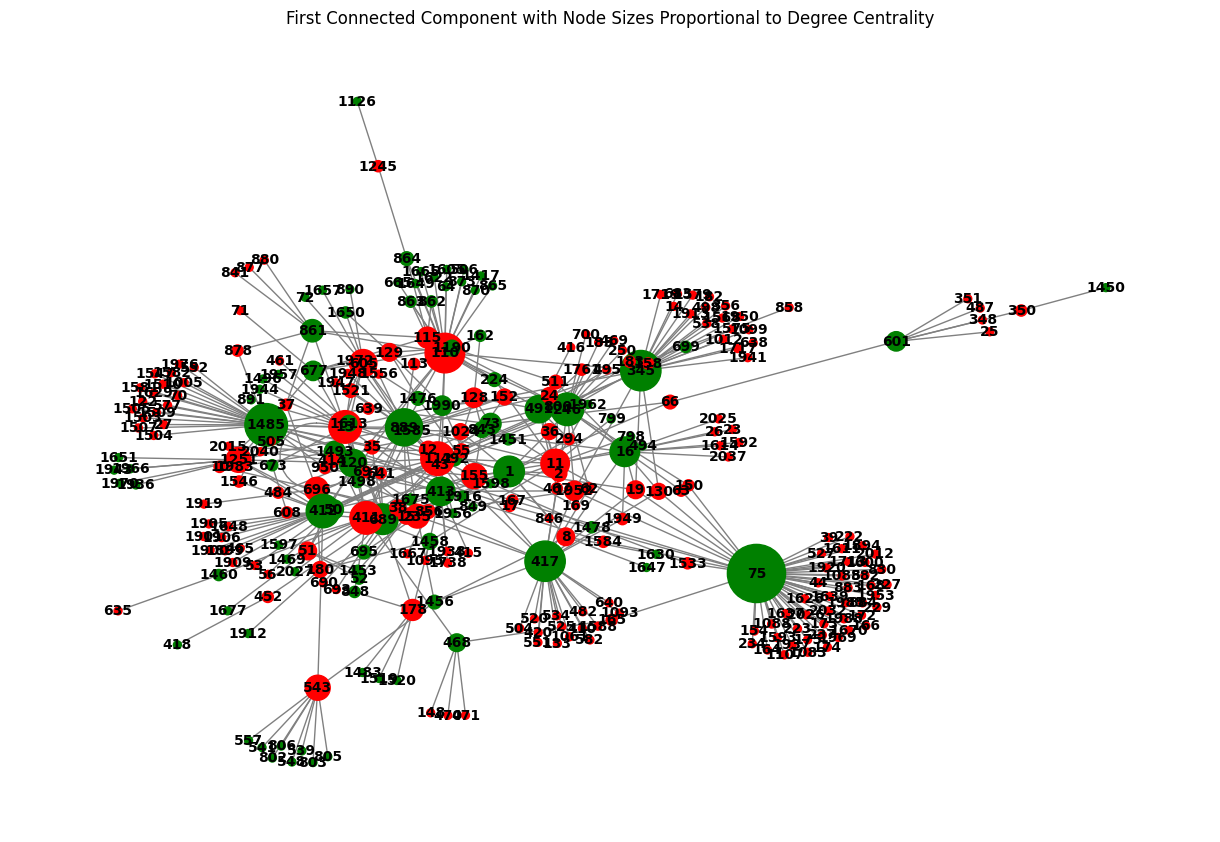

In [24]:
# First connected component subgraph with node sizes proportional to a centrality measure
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=12)  # seed for reproducibility

node_size = [
    v * 10000 for v in degree_centrality.values()
]  # Adjust node size based on degree centrality
# Determine node colors: red for buyers, green for sellers
node_colors = [
    "red" if node in buyer_seller_pairs["buyer_id"].values else "green"
    for node in first_component_subgraph.nodes()
]
nx.draw(
    first_component_subgraph,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color=node_colors,
    font_size=10,
    font_weight="bold",
    edge_color="gray",
)
plt.title("First Connected Component with Node Sizes Proportional to Degree Centrality")
plt.show()

# Influential nodes


## Top 5 Sellers


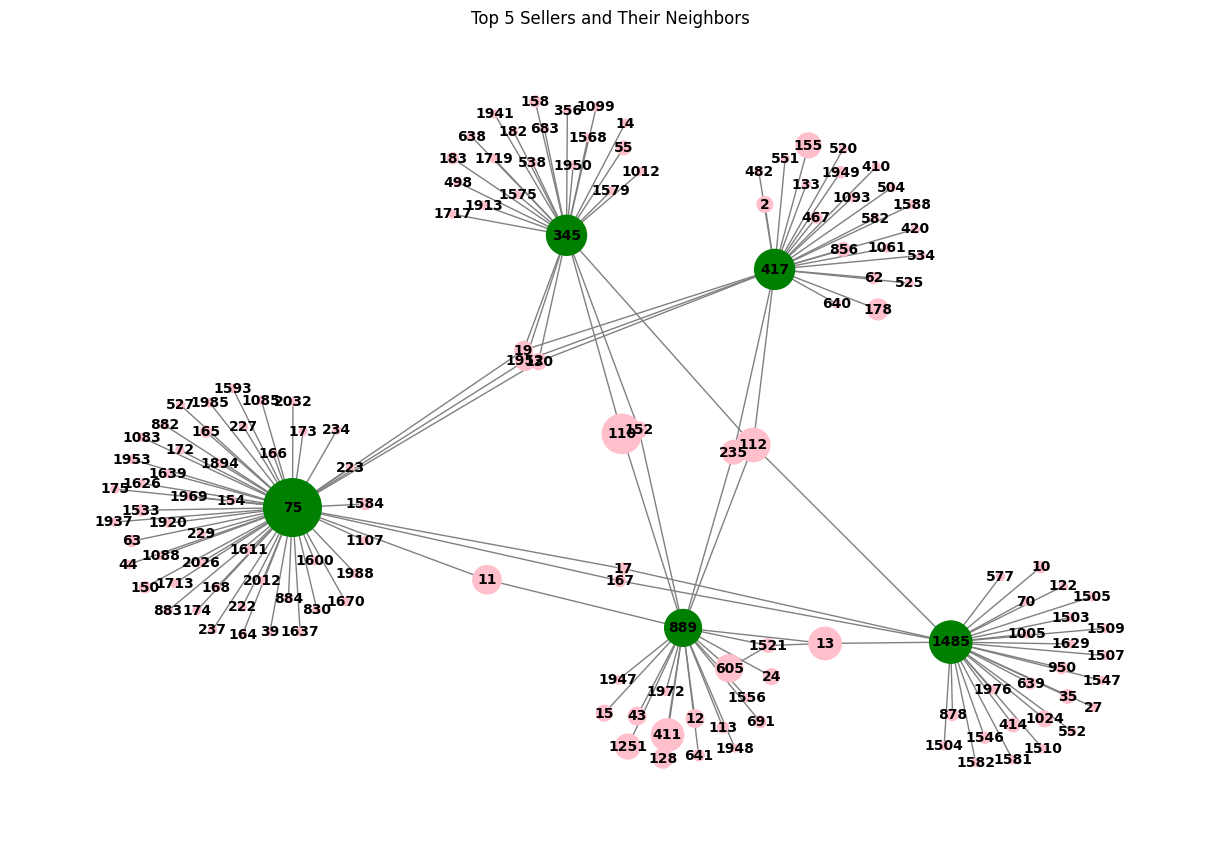

In [10]:
# Calculate degree centrality for all nodes
all_degree_centrality = nx.degree_centrality(G)

# Filter seller nodes and sort by degree centrality
seller_nodes = buyer_seller_pairs["seller_id"].unique()
seller_centrality = {
    node: all_degree_centrality[node]
    for node in seller_nodes
    if node in all_degree_centrality
}
top_5_sellers = sorted(seller_centrality, key=seller_centrality.get, reverse=True)[:5]

# Create a subgraph for the top 5 sellers and their neighbors
subgraph_nodes = set(top_5_sellers)
for seller in top_5_sellers:
    subgraph_nodes.update(G.neighbors(seller))

seller_subgraph = G.subgraph(subgraph_nodes)

# Plot the subgraph
plt.figure(figsize=(12, 8))
subgraph_pos = nx.spring_layout(seller_subgraph, seed=50)

# Adjust node size based on degree centrality
subgraph_node_size = [
    all_degree_centrality[node] * 10000 for node in seller_subgraph.nodes()
]

# Determine node colors: red for top sellers, blue for their neighbors
subgraph_node_colors = [
    "green" if node in top_5_sellers else "pink" for node in seller_subgraph.nodes()
]

nx.draw(
    seller_subgraph,
    subgraph_pos,
    with_labels=True,
    node_size=subgraph_node_size,
    node_color=subgraph_node_colors,
    font_size=10,
    font_weight="bold",
    edge_color="gray",
)
plt.title("Top 5 Sellers and Their Neighbors")
plt.show()

## Top 5 Buyers


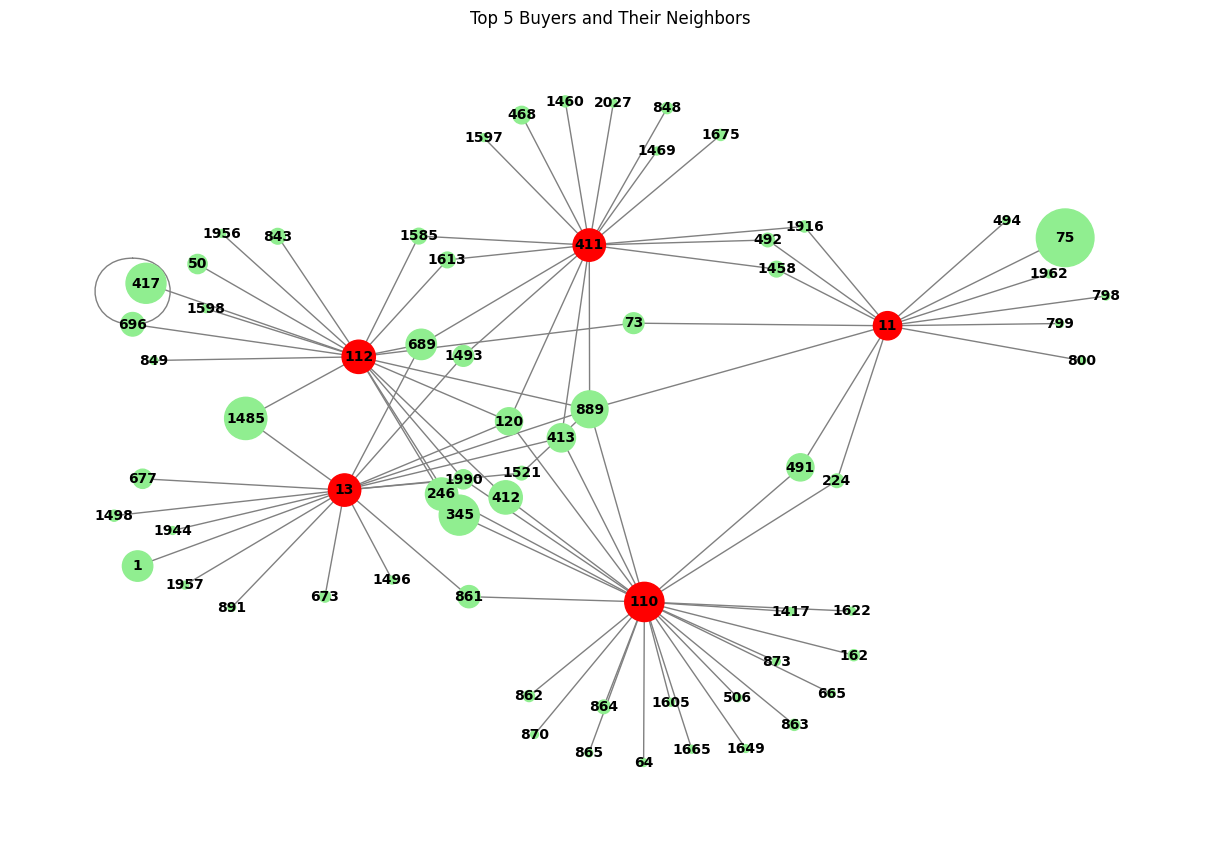

In [11]:
# Calculate degree centrality for all nodes
all_degree_centrality = nx.degree_centrality(G)

# Filter buyer nodes and sort by degree centrality
buyer_nodes = buyer_seller_pairs["buyer_id"].unique()
buyer_centrality = {
    node: all_degree_centrality[node]
    for node in buyer_nodes
    if node in all_degree_centrality
}
top_5_buyers = sorted(buyer_centrality, key=buyer_centrality.get, reverse=True)[:5]

# Create a subgraph for the top 5 buyers and their neighbors
buyer_subgraph_nodes = set(top_5_buyers)
for buyer in top_5_buyers:
    buyer_subgraph_nodes.update(G.neighbors(buyer))

buyer_subgraph = G.subgraph(buyer_subgraph_nodes)

# Plot the subgraph
plt.figure(figsize=(12, 8))
buyer_subgraph_pos = nx.spring_layout(buyer_subgraph, seed=50)

# Adjust node size based on degree centrality
buyer_subgraph_node_size = [
    all_degree_centrality[node] * 10000 for node in buyer_subgraph.nodes()
]

# Determine node colors: blue for top buyers, yellow for their neighbors
buyer_subgraph_node_colors = [
    "red" if node in top_5_buyers else "lightgreen" for node in buyer_subgraph.nodes()
]

nx.draw(
    buyer_subgraph,
    buyer_subgraph_pos,
    with_labels=True,
    node_size=buyer_subgraph_node_size,
    node_color=buyer_subgraph_node_colors,
    font_size=10,
    font_weight="bold",
    edge_color="gray",
)
plt.title("Top 5 Buyers and Their Neighbors")
plt.show()

# Network visualisations


## By company


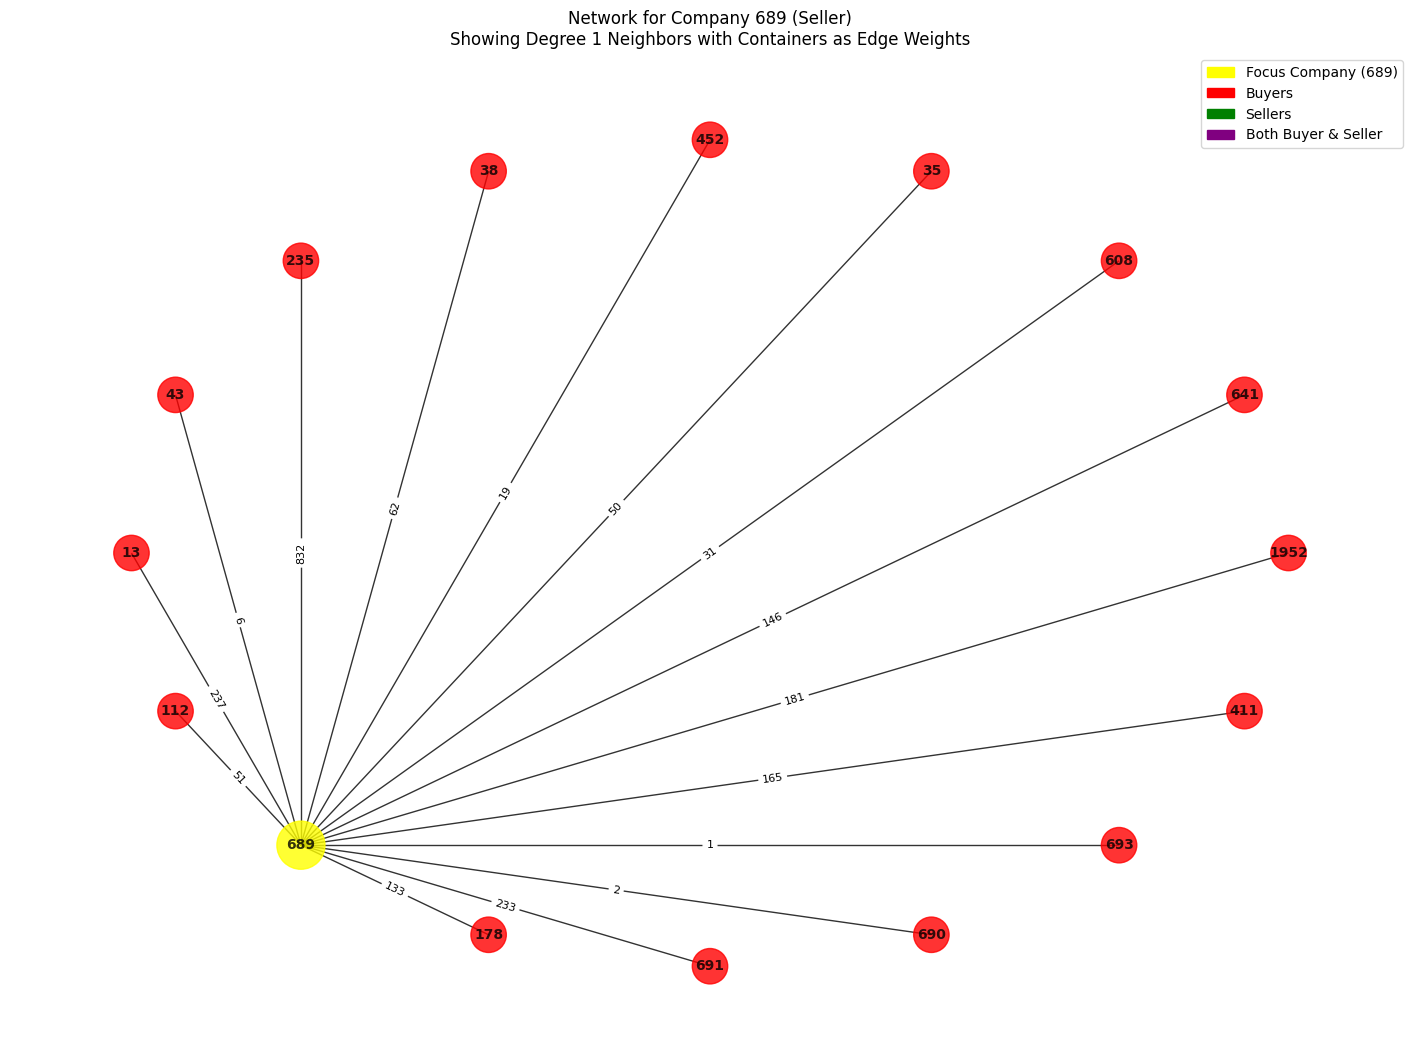


Network Statistics for Company 689 (Seller):
Number of nodes in network: 16
Number of connections: 15

Direct connections: 15
  - Buyers: 15
  - Sellers: 0

Total containers: 2149

Top 5 strongest connections:
1. 235 (Buyer): 832 containers
2. 13 (Buyer): 237 containers
3. 691 (Buyer): 233 containers
4. 1952 (Buyer): 181 containers
5. 411 (Buyer): 165 containers


In [15]:
from network_analysis import visualize_company_network

visualize_company_network(
    cg_df, company_id=689, measure="containers", degree=1, layout="circular"
)

## By strongest connections


### Rank 1


Top 10 Strongest Buyer-Seller Connections by Containers:
     buyer_id  seller_id  weight
60         24        699    2927
35         13        861    2534
255       411       1469    1364
373      1251       1651    1126
215       180        696    1048
86         51         50     849
231       235        689     832
214       180        695     779
26         12        413     772
116       110        861     611

Rank 1 strongest connection: 24 and 699
Containers: 2927


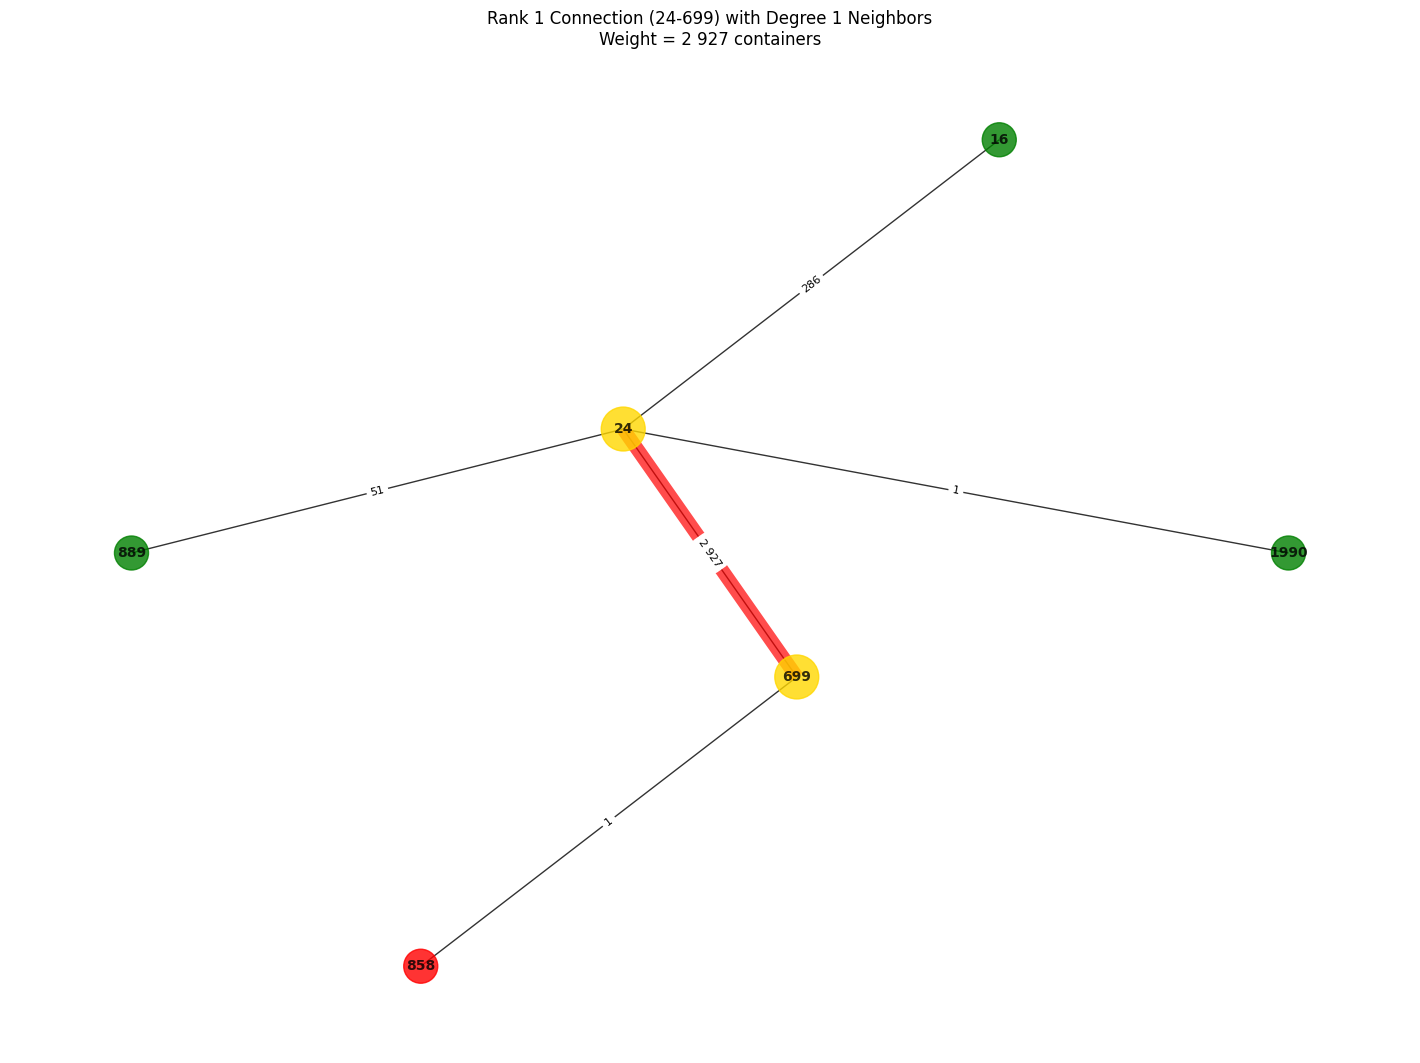


Details about the main nodes:
24 type: Buyer
699 type: Seller
Number of 24's direct connections: 4
Number of 699's direct connections: 2

Total containers for 24: 3 265
Total containers for 699: 2 928

Number of common neighbors: 0
Top 10 Strongest Buyer-Seller Connections by Revenue:
    buyer_id  seller_id           weight
60       235          1  32382182.272395
14        19         75  29504821.243589
6         11         75  29003209.432431
43       167         75  20652152.986477
19        26         16  20595141.268025
10        15          1  19724675.948631
23        44         75  17649061.196311
9         13          1  16161103.283263
22        39         75  14999727.886258
37       155          1  14936916.532784

Rank 1 strongest connection: 235 and 1
Revenue: 32382182.272395037


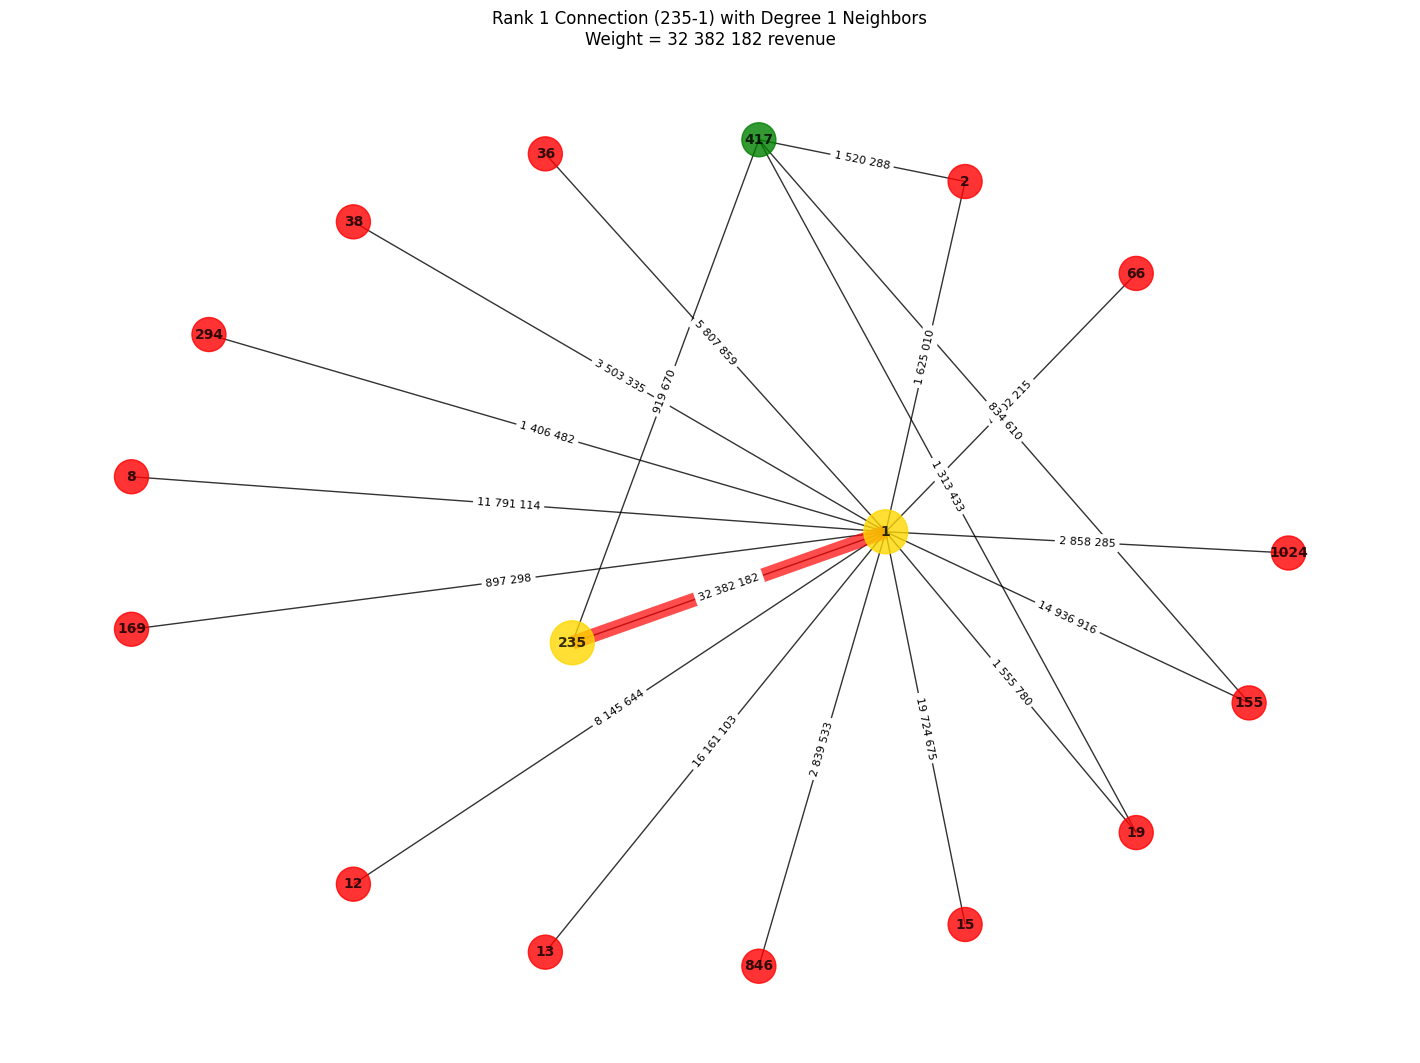


Details about the main nodes:
235 type: Buyer
1 type: Seller
Number of 235's direct connections: 2
Number of 1's direct connections: 15

Total revenue for 235: 33 301 852
Total revenue for 1: 128 537 438

Number of common neighbors: 0


In [68]:
from network_analysis import visualize_strong_connections

# For very connected graphs, Kamada-Kawai often works well
visualize_strong_connections(
    cg_df, rank=1, measure="containers", degree=1, layout="circular"
)
visualize_strong_connections(
    cg_df, rank=1, measure="revenue", degree=1, layout="circular"
)

### Rank 2


Top 10 Strongest Buyer-Seller Connections by Containers:
     buyer_id  seller_id  weight
60         24        699    2927
35         13        861    2534
255       411       1469    1364
373      1251       1651    1126
215       180        696    1048
86         51         50     849
231       235        689     832
214       180        695     779
26         12        413     772
116       110        861     611

Rank 2 strongest connection: 13 and 861
Containers: 2534


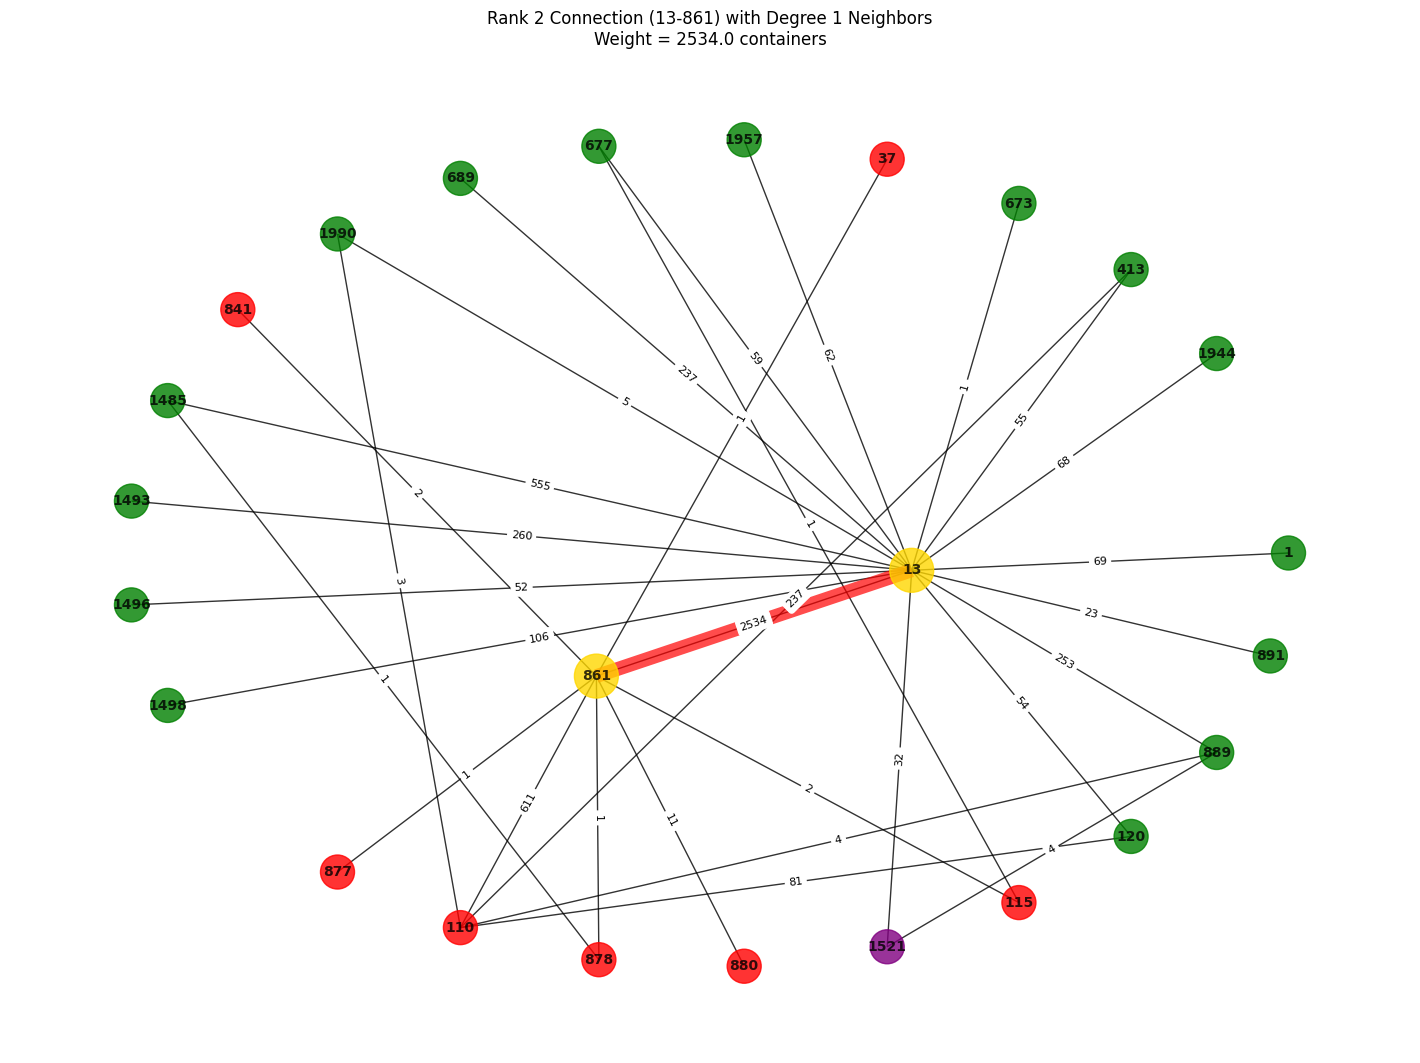


Details about the main nodes:
13 type: Buyer
861 type: Seller
Number of 13's direct connections: 17
Number of 861's direct connections: 8

Total containers for 13: 4425.0
Total containers for 861: 3163.0

Number of common neighbors: 0


In [26]:
visualize_strong_connections(
    cg_df, rank=2, measure="containers", degree=1, layout="circular"
)

### Rank 3


Top 10 Strongest Buyer-Seller Connections by Containers:
     buyer_id  seller_id  weight
60         24        699    2927
35         13        861    2534
255       411       1469    1364
373      1251       1651    1126
215       180        696    1048
86         51         50     849
231       235        689     832
214       180        695     779
26         12        413     772
116       110        861     611

Rank 3 strongest connection: 411 and 1469
Containers: 1364


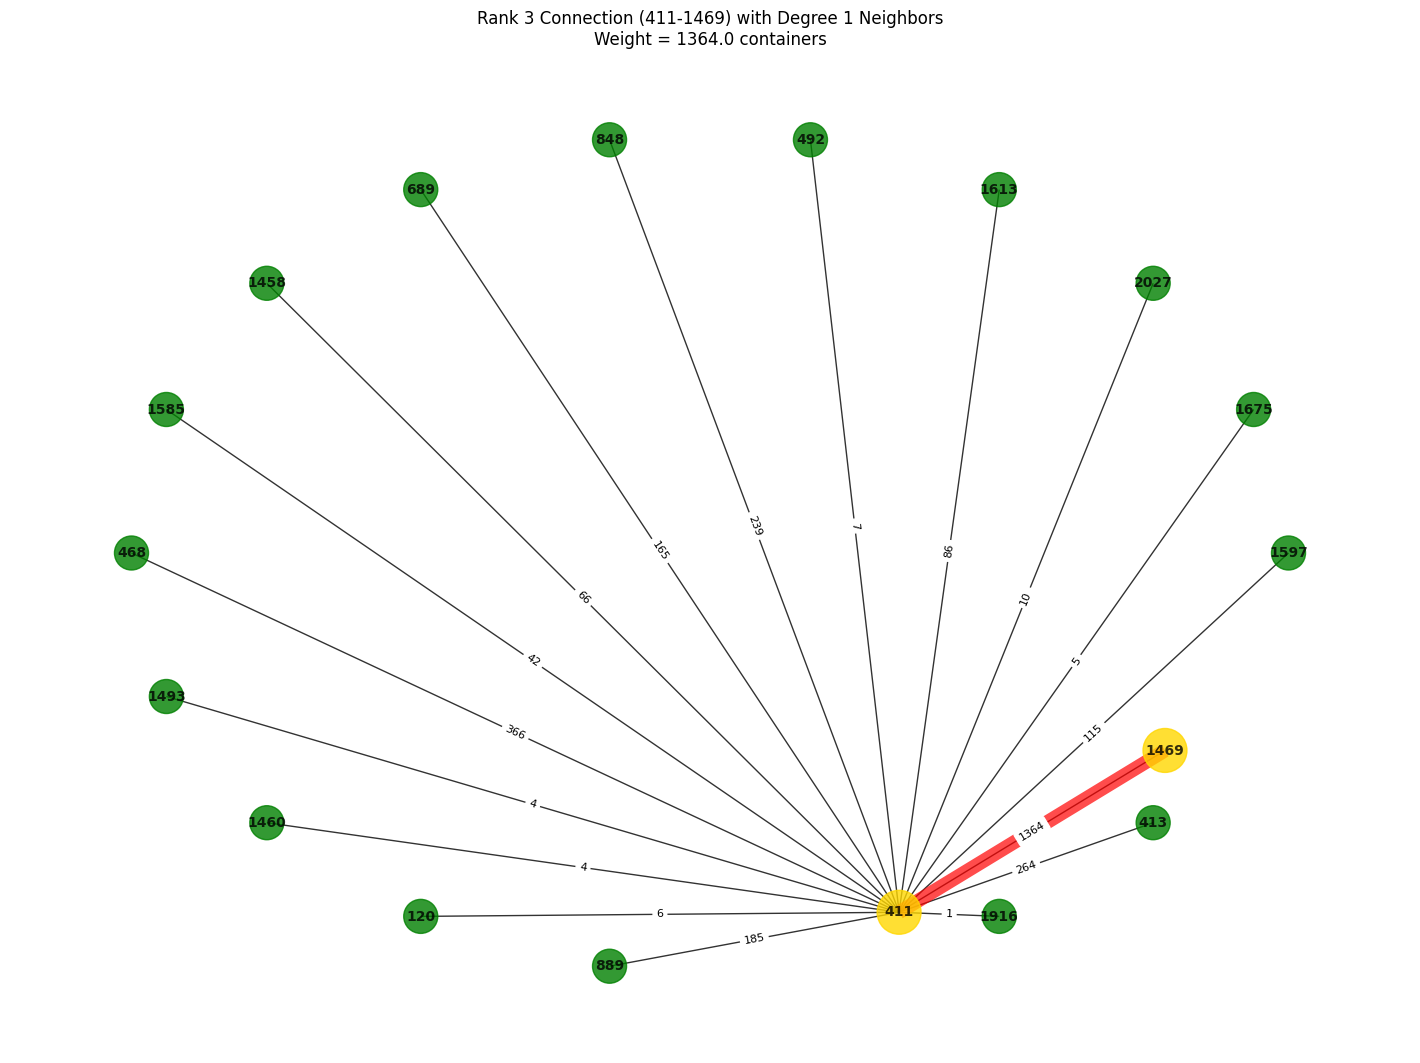


Details about the main nodes:
411 type: Buyer
1469 type: Seller
Number of 411's direct connections: 17
Number of 1469's direct connections: 1

Total containers for 411: 2929.0
Total containers for 1469: 1364.0

Number of common neighbors: 0


In [27]:
visualize_strong_connections(
    cg_df, rank=3, measure="containers", degree=1, layout="circular"
)

## Over time

We visualise the network per packing week to see how it evolves over time.


In [12]:
# Calculate proportion of missing packing weeks
total_cgs = len(cg_df)
null_packing_week_count = cg_df["packing_week"].isna().sum()
none_packing_week_count = cg_df[cg_df["packing_week"] == "None"].shape[0]
invalid_packing_week_count = null_packing_week_count + none_packing_week_count
invalid_packing_week_proportion = invalid_packing_week_count / total_cgs * 100

print(f"Total carton groupings: {total_cgs}")
print(
    f"Carton groupings with null packing week: {null_packing_week_count} ({null_packing_week_count/total_cgs*100:.2f}%)"
)
print(
    f"Carton groupings with 'None' packing week: {none_packing_week_count} ({none_packing_week_count/total_cgs*100:.2f}%)"
)
print(
    f"Total invalid packing weeks: {invalid_packing_week_count} ({invalid_packing_week_proportion:.2f}%)"
)

# Filter out rows with null packing_week values or 'None' values
network_df = cg_df.dropna(subset=["buyer_id", "seller_id", "packing_week"])
network_df = network_df[network_df["packing_week"] != "None"]
print(
    f"Remaining carton groupings after filtering: {len(network_df)} ({len(network_df)/total_cgs*100:.2f}%)"
)

# Get the unique weeks in sorted order
unique_weeks = sorted(network_df["packing_week"].unique())
print(f"Number of unique packing weeks: {len(unique_weeks)}")

Total carton groupings: 826688
Carton groupings with null packing week: 0 (0.00%)
Carton groupings with 'None' packing week: 12135 (1.47%)
Total invalid packing weeks: 12135 (1.47%)
Remaining carton groupings after filtering: 712805 (86.22%)
Number of unique packing weeks: 51


In [13]:
# Network over time animation
from network_analysis import create_network_timelapse
from IPython.display import HTML

# Create the network timelapse animation
ani = create_network_timelapse(
    network_df,  # Your pre-filtered DataFrame
    output_path=OUTPUT_NET_PATH
    / "network_timelapse.gif",  # Where to save the animation
    interval=1500,  # Milliseconds between frames when displayed
    fps=1,  # Frames per second for the saved file
    figsize=(12, 8),  # Figure size
    seed=42,  # Random seed for layout consistency
)

# Display the animation in the notebook
HTML(ani.to_jshtml())